In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Optimisation

The goal is to play around with different optimisation methods. I will try to understand them, code them up from scratch, and try them out on some cool objective functions. If I have time, I will try to use Jax or some other autograd library to do additional implementations of the gradient-based optimisation methods.

## Optimisation Methods

### Steepest Descent / Gradient Descent

Taylor's theorem implies that:
$$f(\theta + \Delta) \simeq f(\theta) + \nabla f(\theta)^{T} \cdot \Delta $$
Which will be minimised in $\Delta$ by setting $\Delta \propto -\nabla f(\theta) $. Using this as our direction for selecting the next $\theta$, one would still need to choose an appropriate step length, telling us how far to go in that direction. First, we consider a fixed step size, giving: $\Delta = \alpha \cdot -\nabla f(\theta), \, \alpha \in \mathbb{R}^{+}$.

In [23]:
# Let's code it!

def GD_method(theta_0,f,grad,alpha,method='Iterations',maxiter=100,epsilon=10e-2):
    
    iter_count = 0
    theta_list = [np.array(theta_0)]

    while True:

        cur_theta = theta_list[iter_count]
        theta_list.append(cur_theta + alpha * -grad(cur_theta))
        iter_count+=1

        if method == 'Iterations':
            if iter_count>maxiter:

                print('Max number of iterations reached: '+str(maxiter))
                print('Final objective function value '+str(f(theta_list[-1]))+' reached at '+str(theta_list[-1]))
                return theta_list

        if method == 'Epsilon':
            if np.abs(f(cur_theta)-f(theta_list[-1]))<epsilon:
                print('Minimal tolerance reached with number of iterations: '+str(iter_count))
                print('Final objective function value '+str(f(theta_list[-1]))+' reached at '+str(theta_list[-1]))
                return theta_list


## Objective Functions

## X^2

Minimal tolerance reached with number of iterations: 10
Final objective function value 7.036874417766373e-07 reached at 0.0008388607999999984


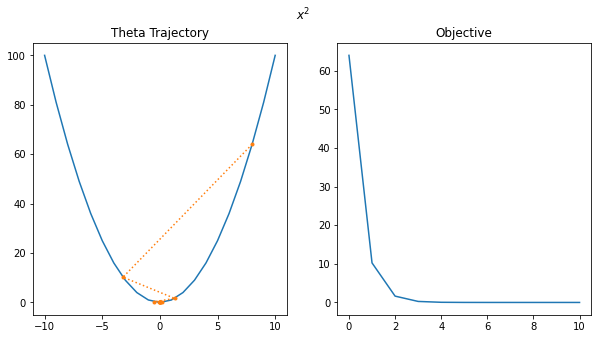

In [110]:
def x2(x):
    return np.power(x,2)
def x2_grad(x):
    return 2*x

theta_vals = GD_method(8,x2,x2_grad,0.7,method='Epsilon',epsilon=10e-6)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('$x^2$')
ax1.plot(range(-10,11),[x2(x) for x in range(-10,11)])
ax1.plot(theta_vals,[x2(i) for i in theta_vals],marker='o',linestyle='dotted',markersize=3)
ax1.set_title('Theta Trajectory')
ax2.plot([x2(x) for x in theta_vals])
ax2.set_title('Objective')
fig.set_size_inches(10,5)
plt.show()

### Rosenbrock function

This is a non-convex function defined by:
$$ f(x,y) = (a-x)^2 +b(y-x^2)^2 $$ 
for $a,b \in \mathbb{R}$. Here I take $a=1, b=100$ which seems to be the reference example. The function always has a global minimum at $(a,a^2)$.
Then, this function has a gradient of $\nabla f(x,y) = (400x^3-400xy+2x-2,\,200(y-x^2))$.

Minimal tolerance reached with number of iterations: 139
Final objective function value 2403.365937218817 reached at [-0.09144173 -4.89283693]


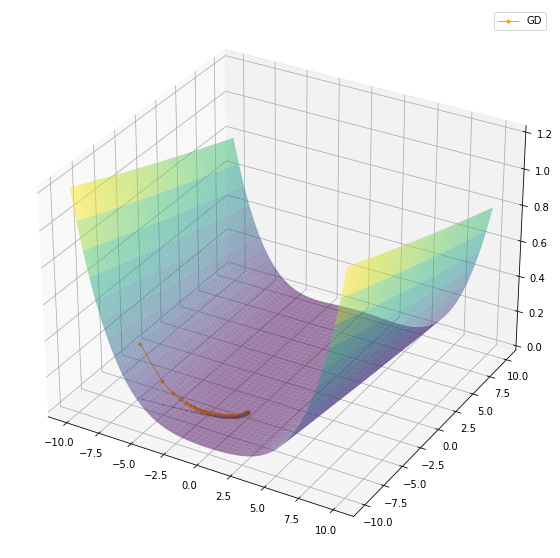

In [170]:
def Ros(theta,a=1,b=100):
    x,y=theta
    return np.power((a-x),2) + b*np.power((y-np.power(x,2)),2)
def Ros_grad(theta):
    x,y=theta
    return np.array([400*np.power(x,3)-400*x*y+2*x-2, 200*(y-np.power(x,2))])

x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)
X, Y = np.meshgrid(x, y)
Z = Ros([X, Y])
%matplotlib inline
fig = plt.figure()
fig.set_size_inches(10,10)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none',alpha=0.5)

theta_vals = GD_method([-7,-7],Ros,Ros_grad,10e-6,method='Epsilon',epsilon=10)

ax.plot3D([i[0] for i in theta_vals],[i[1] for i in theta_vals],[Ros(i)+5 for i in theta_vals],color='orange',label='GD',linewidth=1,marker='o',markersize=3)
ax.plot3D([i[0] for i in theta_vals],[i[1] for i in theta_vals],[0 for i in theta_vals],color='grey',linewidth=1,marker='o',markersize=1,alpha=0.5)

plt.legend()
plt.show()

In [129]:
GD_method([7,-7],Ros,Ros_grad,10e-6,method='Epsilon',epsilon=1)

Minimal tolerance reached with number of iterations: 704
Final objective function value 250.17149852076628 reached at [ 0.00262302 -1.57852642]


[array([ 7, -7]),
 array([ 5.43188, -6.888  ]),
 array([ 4.64105477, -6.81521336]),
 array([ 4.11460089, -6.75850415]),
 array([ 3.72466462, -6.71112726]),
 array([ 3.41793236, -6.66995876]),
 array([ 3.16697741, -6.63325432]),
 array([ 2.95584869, -6.59992832]),
 array([ 2.77447452, -6.56925438]),
 array([ 2.61610573, -6.54072045]),
 array([ 2.47600993, -6.51395099]),
 array([ 2.35074803, -6.48866184]),
 array([ 2.23774709, -6.46463248]),
 array([ 2.1350353 , -6.44168819]),
 array([ 2.0410705 , -6.41968807]),
 array([ 1.95462539, -6.39851675]),
 array([ 1.87470843, -6.3780786 ]),
 array([ 1.8005079 , -6.35829338]),
 array([ 1.7313515 , -6.33909313]),
 array([ 1.66667664, -6.32041979]),
 array([ 1.60600807, -6.30222333]),
 array([ 1.548941  , -6.28446036]),
 array([ 1.495128, -6.267093]),
 array([ 1.44426879, -6.250088  ]),
 array([ 1.3961022, -6.233416 ]),
 array([ 1.35039976, -6.21705096]),
 array([ 1.30696049, -6.2009697 ]),
 array([ 1.26560675, -6.18515147]),
 array([ 1.22618076, -